In [1]:
import tensorflow as tf
import numpy as np
from cv2 import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K

tf.get_logger().setLevel('ERROR')

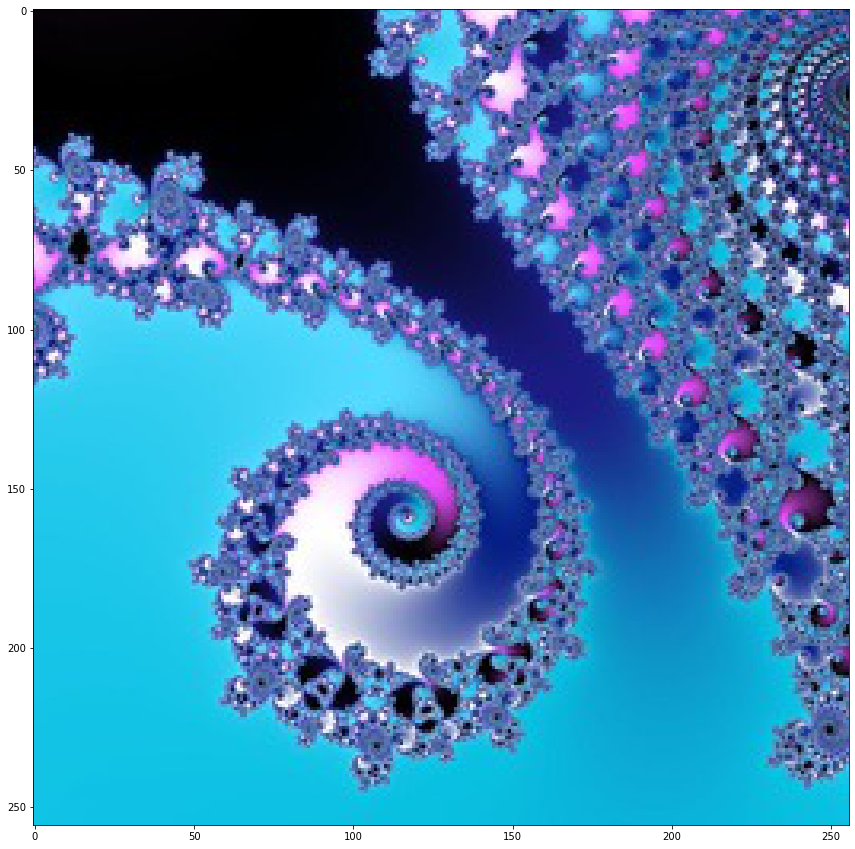

In [2]:
image = Image.open('dataset/fractal.jpg')
image = np.asarray(image)
image = image / 255.0

plt.figure(figsize=(15, 15))
plt.imshow(image)

In [3]:
from NeRF2D import Positional_Encoding

# Get dataset
positional_encoding = Positional_Encoding(image, 'sin_cos')
positions, _, indices = positional_encoding.get_dataset(shuffle=False)

# Get output from model
model = tf.keras.models.load_model('./saved_model/128x2_sin_cos_5e-04_fractal')
model.summary()

output = model(positions, training=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22,147
Trainable params: 22,147
Non-trainable params: 0
_________________________________________________________________


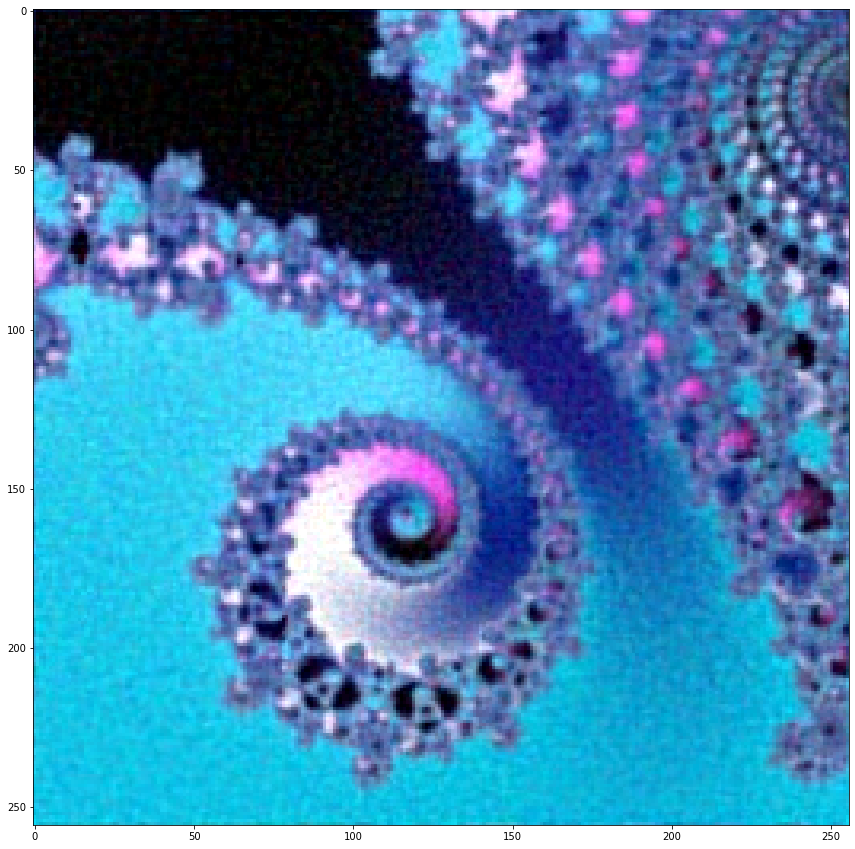

In [4]:
predicted_image = np.zeros_like(image)

indices = indices.astype('int')
indices = indices[:, 1] * image.shape[1] + indices[:, 0]

np.put(predicted_image[:, :, 0], indices, np.clip((output[:, 0]+1)/2.0, 0, 1))
np.put(predicted_image[:, :, 1], indices, np.clip((output[:, 1]+1)/2.0, 0, 1))
np.put(predicted_image[:, :, 2], indices, np.clip((output[:, 2]+1)/2.0, 0, 1))

plt.figure(figsize=(15, 15))
plt.imshow(predicted_image)

Amount of unique activation patterns in layer 1: 64963


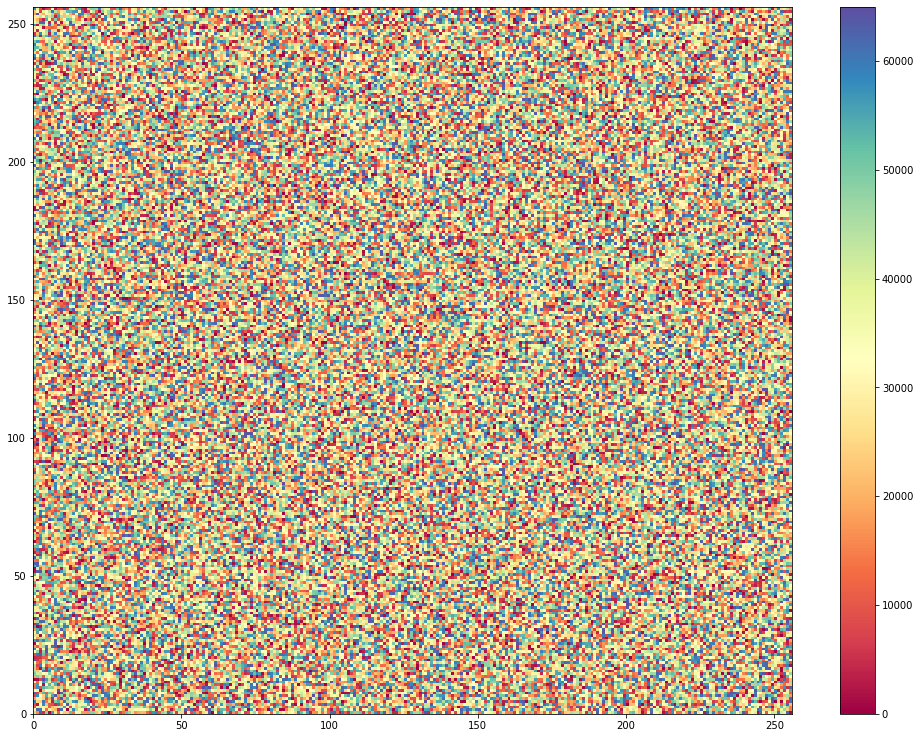

In [5]:
# Get the activations
activations1 = K.function([model.input], [model.layers[0].output])

# Pass in data to layers
activations1_output = activations1([positions])
activations1_output = np.squeeze(activations1_output)
for i, pixel in enumerate(activations1_output):
    for j, output in enumerate(pixel):
        if output > 0:
            activations1_output[i][j] = 1
        else:
            activations1_output[i][j] = 0

# Get the amount of unique activation regions
activations1_tuples = [tuple(x) for x in activations1_output.tolist()]
unique_patterns = set(activations1_tuples)
print("Amount of unique activation patterns in layer 1: {}".format(len(unique_patterns)))

# create a dictionary to assign each unique activation a color
colors = {}
for i, activation in enumerate(unique_patterns):
	colors[activation] = i

# Go through the original data and assign each vector a color instead
activations1_colors = []
for activation in activations1_tuples:
	activations1_colors.append(colors[activation])

# Reshape and plot
activations1_colors = np.array(activations1_colors)
activations1_colors = np.reshape(activations1_colors, (256, 256))

plt.figure(figsize=(17, 13))
plt.pcolormesh(activations1_colors, cmap='Spectral')
plt.colorbar()
plt.savefig('activations1_sin_cos.jpg')

Amount of unique activation patterns in layer 2: 62848


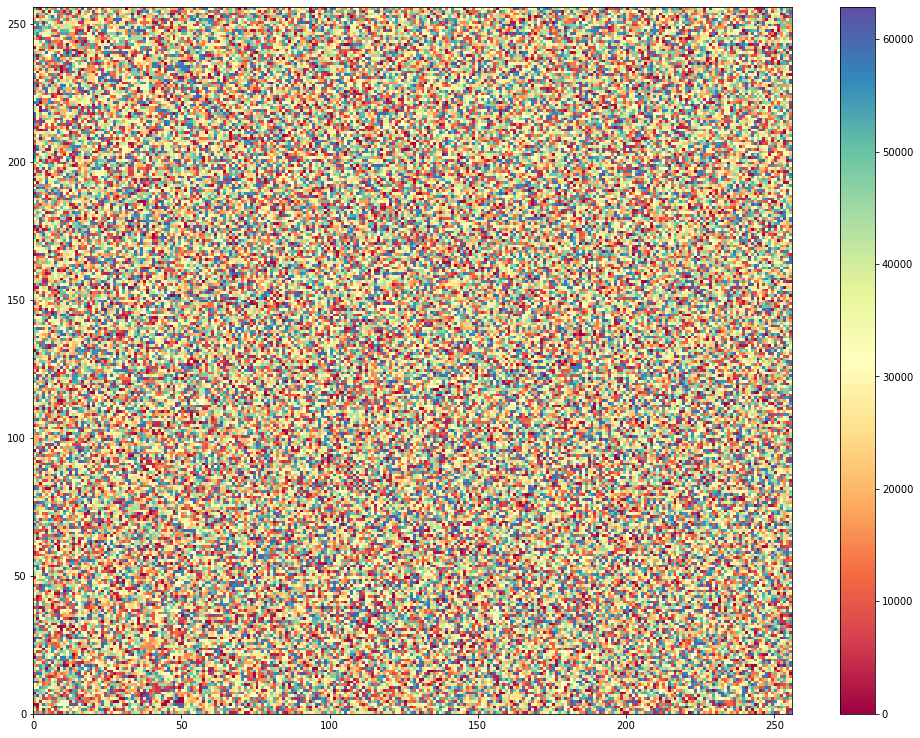

In [6]:
# Get the activations
activations2 = K.function([model.input], [model.layers[1].output])

# Pass in data to layers
activations2_output = activations2([positions])
activations2_output = np.squeeze(activations2_output)
for i, pixel in enumerate(activations2_output):
    for j, output in enumerate(pixel):
        if output > 0:
            activations2_output[i][j] = 1
        else:
            activations2_output[i][j] = 0

# Get the amount of unique activation regions
activations2_tuples = [tuple(x) for x in activations2_output.tolist()]
unique_patterns = set(activations2_tuples)
print("Amount of unique activation patterns in layer 2: {}".format(len(unique_patterns)))

# create a dictionary to assign each unique activation a color
colors = {}
for i, activation in enumerate(unique_patterns):
	colors[activation] = i

# Go through the original data and assign each vector a color instead
activations2_colors = []
for activation in activations2_tuples:
	activations2_colors.append(colors[activation])

# Reshape and plot
activations2_colors = np.array(activations2_colors)
activations2_colors = np.reshape(activations2_colors, (256, 256))

plt.figure(figsize=(17, 13))
plt.pcolormesh(activations2_colors, cmap='Spectral')
plt.colorbar()
plt.savefig('activations2_sin_cos.jpg')

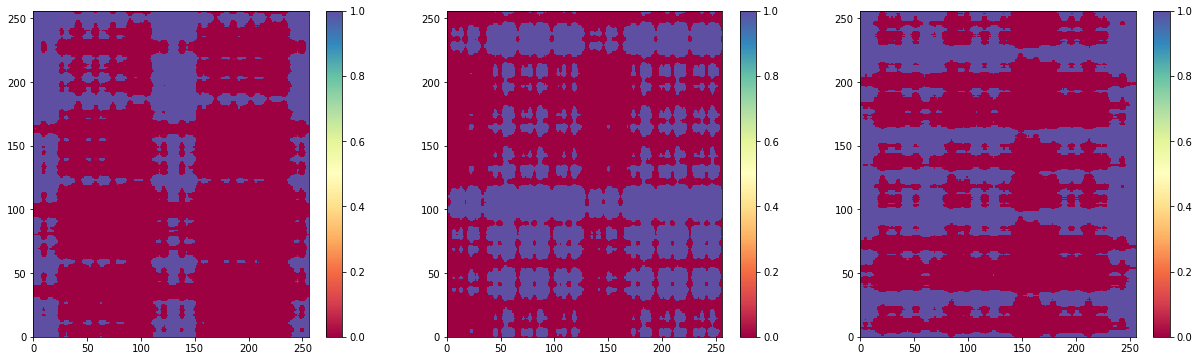

In [7]:
# Get the activations
activations1 = K.function([model.input], [model.layers[0].output])

# Pass in data to layers
activations1_output = activations1([positions])
activations1_output = np.squeeze(activations1_output)

# Get first three neurons
first_three_neurons = activations1_output[:, :3]
for i, pixel in enumerate(first_three_neurons):
    for j, output in enumerate(pixel):
        if output > 0:
            first_three_neurons[i][j] = 1
        else:
            first_three_neurons[i][j] = 0

# Reshape and plot
first_three_neurons = np.array(first_three_neurons)
first_three_neurons = np.reshape(first_three_neurons, (256, 256, 3))
neuron1 = first_three_neurons[:, :, 0]
neuron2 = first_three_neurons[:, :, 1]
neuron3 = first_three_neurons[:, :, 2]

fig = plt.figure(figsize=(21, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pcm1 = ax1.pcolormesh(neuron1, cmap='Spectral')
pcm2 = ax2.pcolormesh(neuron2, cmap='Spectral')
pcm3 = ax3.pcolormesh(neuron3, cmap='Spectral')

fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)
fig.colorbar(pcm3, ax=ax3)

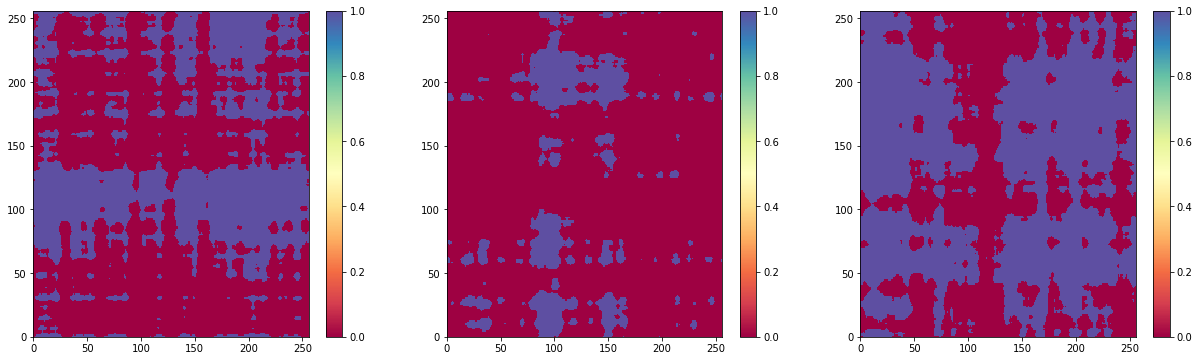

In [8]:
# Get the activations
activations2 = K.function([model.input], [model.layers[1].output])

# Pass in data to layers
activations2_output = activations2([positions])
activations2_output = np.squeeze(activations2_output)

# Get first three neurons
first_three_neurons = activations2_output[:, :3]
for i, pixel in enumerate(first_three_neurons):
    for j, output in enumerate(pixel):
        if output > 0:
            first_three_neurons[i][j] = 1
        else:
            first_three_neurons[i][j] = 0

# Reshape and plot
first_three_neurons = np.array(first_three_neurons)
first_three_neurons = np.reshape(first_three_neurons, (256, 256, 3))
neuron1 = first_three_neurons[:, :, 0]
neuron2 = first_three_neurons[:, :, 1]
neuron3 = first_three_neurons[:, :, 2]

fig = plt.figure(figsize=(21, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pcm1 = ax1.pcolormesh(neuron1, cmap='Spectral')
pcm2 = ax2.pcolormesh(neuron2, cmap='Spectral')
pcm3 = ax3.pcolormesh(neuron3, cmap='Spectral')

fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)
fig.colorbar(pcm3, ax=ax3)

In [9]:
from NeRF2D import Positional_Encoding

# Get dataset
positional_encoding = Positional_Encoding(image, 'repeat_xy')
positions, _, indices = positional_encoding.get_dataset(shuffle=False)

# Get output from model
model = tf.keras.models.load_model('./saved_model/128x2_repeat_xy_5e-04_fractal')
model.summary()

output = model(positions, training=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22,147
Trainable params: 22,147
Non-trainable params: 0
_________________________________________________________________


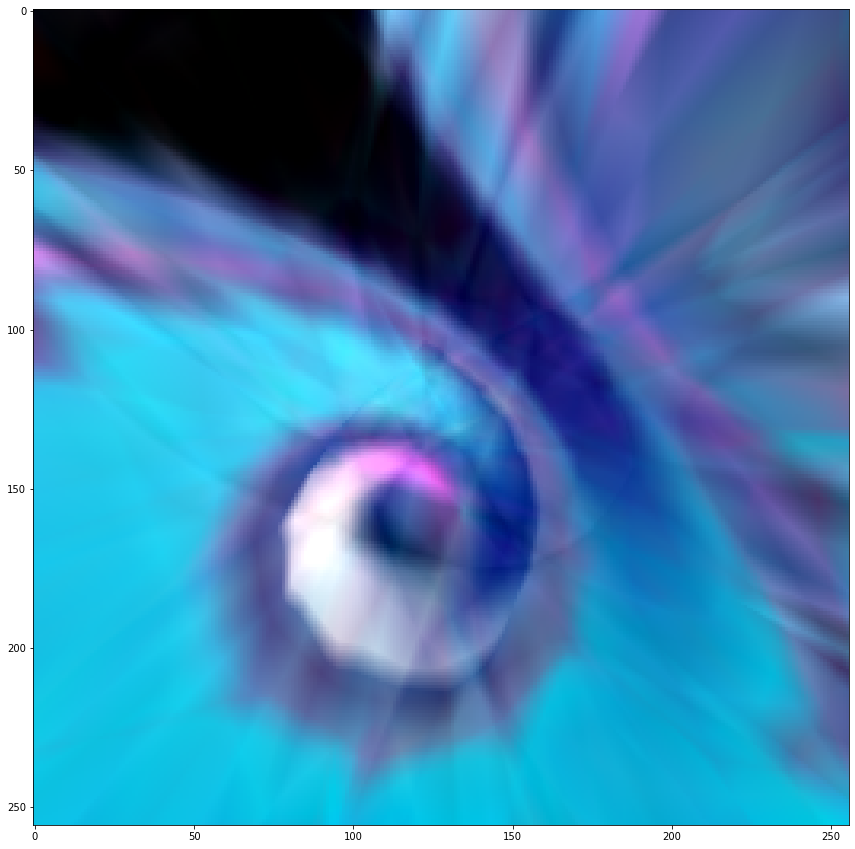

In [10]:
predicted_image = np.zeros_like(image)

indices = indices.astype('int')
indices = indices[:, 1] * image.shape[1] + indices[:, 0]

np.put(predicted_image[:, :, 0], indices, np.clip((output[:, 0]+1)/2.0, 0, 1))
np.put(predicted_image[:, :, 1], indices, np.clip((output[:, 1]+1)/2.0, 0, 1))
np.put(predicted_image[:, :, 2], indices, np.clip((output[:, 2]+1)/2.0, 0, 1))

plt.figure(figsize=(15, 15))
plt.imshow(predicted_image)

Amount of unique activation patterns in layer 1: 3841


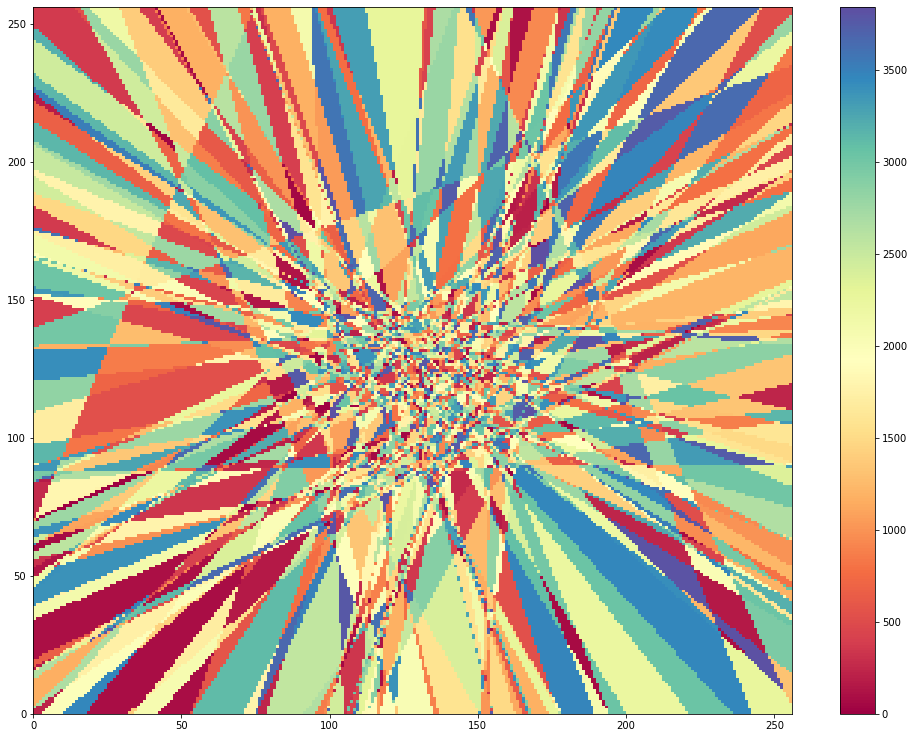

In [11]:
# Get the activations
activations1 = K.function([model.input], [model.layers[0].output])

# Pass in data to layers
activations1_output = activations1([positions])
activations1_output = np.squeeze(activations1_output)
for i, pixel in enumerate(activations1_output):
    for j, output in enumerate(pixel):
        if output > 0:
            activations1_output[i][j] = 1
        else:
            activations1_output[i][j] = 0

# Get the amount of unique activation regions
activations1_tuples = [tuple(x) for x in activations1_output.tolist()]
unique_patterns = set(activations1_tuples)
print("Amount of unique activation patterns in layer 1: {}".format(len(unique_patterns)))

# create a dictionary to assign each unique activation a color
colors = {}
for i, activation in enumerate(unique_patterns):
	colors[activation] = i

# Go through the original data and assign each vector a color instead
activations1_colors = []
for activation in activations1_tuples:
	activations1_colors.append(colors[activation])

# Reshape and plot
activations1_colors = np.array(activations1_colors)
activations1_colors = np.reshape(activations1_colors, (256, 256))

plt.figure(figsize=(17, 13))
plt.pcolormesh(activations1_colors, cmap='Spectral')
plt.colorbar()
plt.savefig('activations1_repeat_xy.jpg')

Amount of unique activation patterns in layer 2: 6980


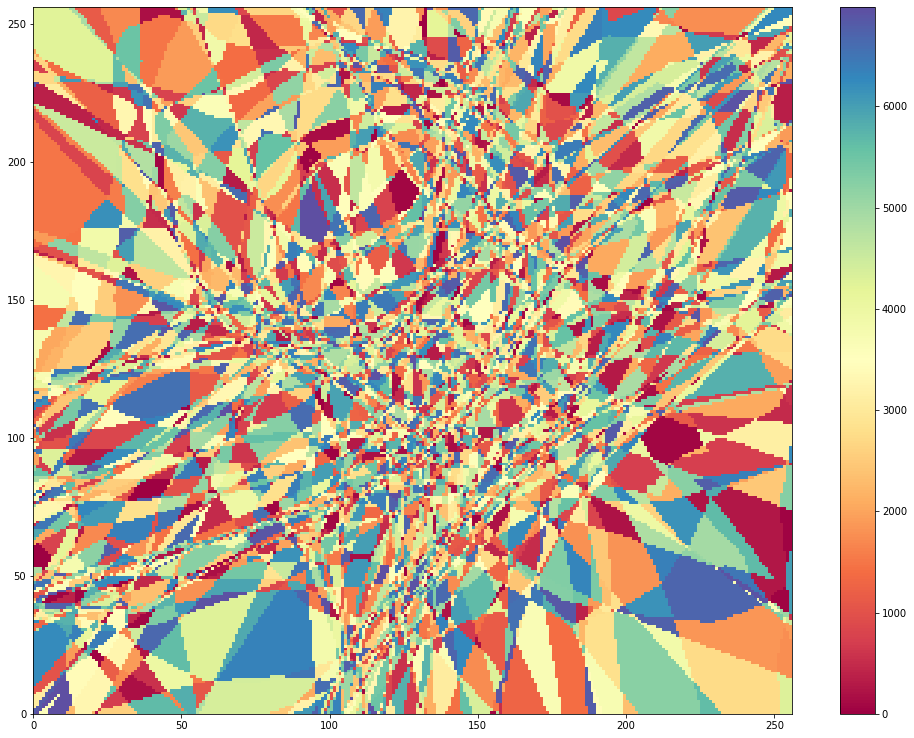

In [12]:
# Get the activations
activations2 = K.function([model.input], [model.layers[1].output])

# Pass in data to layers
activations2_output = activations2([positions])
activations2_output = np.squeeze(activations2_output)
for i, pixel in enumerate(activations2_output):
    for j, output in enumerate(pixel):
        if output > 0:
            activations2_output[i][j] = 1
        else:
            activations2_output[i][j] = 0

# Get the amount of unique activation regions
activations2_tuples = [tuple(x) for x in activations2_output.tolist()]
unique_patterns = set(activations2_tuples)
print("Amount of unique activation patterns in layer 2: {}".format(len(unique_patterns)))

# create a dictionary to assign each unique activation a color
colors = {}
for i, pixel in enumerate(unique_patterns):
	colors[pixel] = i

# Go through the original data and assign each vector a color instead
activations2_colors = []
for activation in activations2_tuples:
	activations2_colors.append(colors[activation])

# Reshape and plot
activations2_colors = np.array(activations2_colors)
activations2_colors = np.reshape(activations2_colors, (256, 256))

plt.figure(figsize=(17, 13))
plt.pcolormesh(activations2_colors, cmap='Spectral')
plt.colorbar()
plt.savefig('activations2_repeat_xy.jpg')

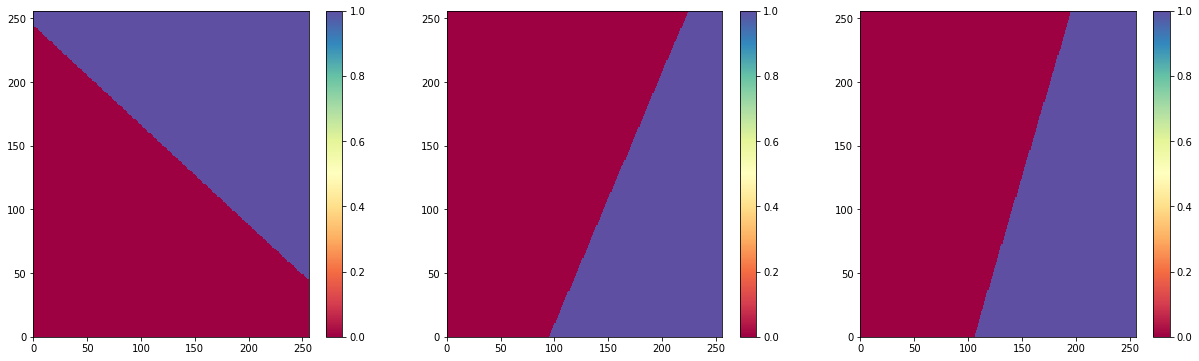

In [13]:
# Get the activations
activations1 = K.function([model.input], [model.layers[0].output])

# Pass in data to layers
activations1_output = activations1([positions])
activations1_output = np.squeeze(activations1_output)

# Get first three neurons
first_three_neurons = activations1_output[:, :3]
for i, pixel in enumerate(first_three_neurons):
    for j, output in enumerate(pixel):
        if output > 0:
            first_three_neurons[i][j] = 1
        else:
            first_three_neurons[i][j] = 0

# Reshape and plot
first_three_neurons = np.array(first_three_neurons)
first_three_neurons = np.reshape(first_three_neurons, (256, 256, 3))
neuron1 = first_three_neurons[:, :, 0]
neuron2 = first_three_neurons[:, :, 1]
neuron3 = first_three_neurons[:, :, 2]

fig = plt.figure(figsize=(21, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pcm1 = ax1.pcolormesh(neuron1, cmap='Spectral')
pcm2 = ax2.pcolormesh(neuron2, cmap='Spectral')
pcm3 = ax3.pcolormesh(neuron3, cmap='Spectral')

fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)
fig.colorbar(pcm3, ax=ax3)

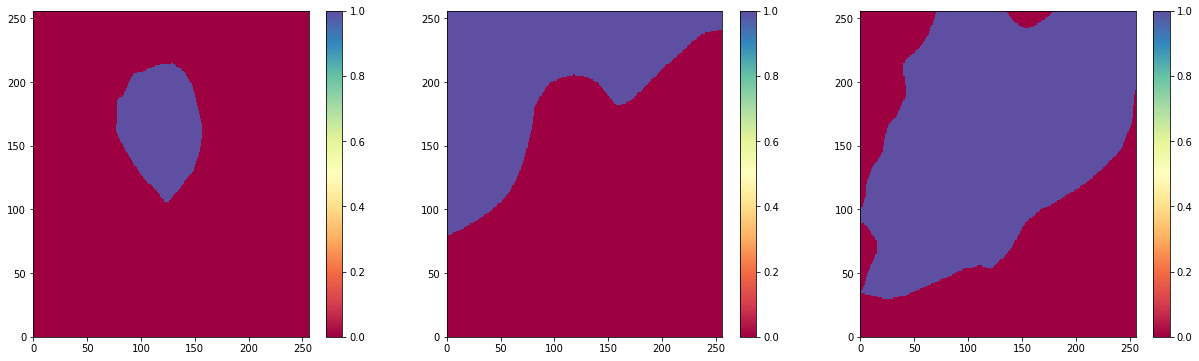

In [14]:
# Get the activations
activations2 = K.function([model.input], [model.layers[1].output])

# Pass in data to layers
activations2_output = activations2([positions])
activations2_output = np.squeeze(activations2_output)

# Get first three neurons
first_three_neurons = activations2_output[:, :3]
for i, pixel in enumerate(first_three_neurons):
    for j, output in enumerate(pixel):
        if output > 0:
            first_three_neurons[i][j] = 1
        else:
            first_three_neurons[i][j] = 0

# Reshape and plot
first_three_neurons = np.array(first_three_neurons)
first_three_neurons = np.reshape(first_three_neurons, (256, 256, 3))
neuron1 = first_three_neurons[:, :, 0]
neuron2 = first_three_neurons[:, :, 1]
neuron3 = first_three_neurons[:, :, 2]

fig = plt.figure(figsize=(21, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pcm1 = ax1.pcolormesh(neuron1, cmap='Spectral')
pcm2 = ax2.pcolormesh(neuron2, cmap='Spectral')
pcm3 = ax3.pcolormesh(neuron3, cmap='Spectral')

fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)
fig.colorbar(pcm3, ax=ax3)